In [1]:
import sys
sys.path.insert(0, '../')
import numpy as np
import pandas as pd
import umap
import matplotlib.pyplot as plt
import torch
from torch import nn
from models.imavae import IMAVAE

# To make this notebook's output stable across runs
np.random.seed(2020)
torch.manual_seed(2020)
torch.cuda.manual_seed(2020)
torch.cuda.manual_seed_all(2020)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# 1. Generate Data without observed covariates

We construct the synthetic data for mediation analysis as below:
\begin{align*}
t &\sim \text{Bernoulli}(p) \\
\boldsymbol{z}_m &\sim \mathcal{N}(0, \sigma_m^2 \textbf{I}) + c_1 \mathbb{1}(t = 1) \\
\boldsymbol{x} &= f(\boldsymbol{z}_m) + c_2 \epsilon_{x} \\
y &= \alpha t + \boldsymbol{\beta}^{\text{T}} \boldsymbol{z}_m + \epsilon_{y}
\end{align*}
where $0 < p < 1$ and $c \in \mathbb{R}$ are constants, $f$ is a nonlinear function which is modeled by an **un-trained** multi-layer perceptron (MLP), $\alpha$ and $\beta$ are the coefficients which build a linear relationship between $\boldsymbol{z}$ and $t, \boldsymbol{y}$, and $\epsilon_{x}$ and $\epsilon_{y}$ are Gaussian noise terms.

In [2]:
N = 6000
p, c1, c2, sigma_m, noise_scale = 0.5, 4, 0.1, 1, 0.1
x_dim, z_m_dim, hidden_dim = 50, 2, 25
f = nn.Sequential(
    nn.Linear(z_m_dim, hidden_dim), 
    nn.LeakyReLU(), 
    nn.Linear(hidden_dim, x_dim)
)

T = np.random.binomial(n=1, p=[p for _ in range(N)]).reshape(-1,1)
Z_m0 = np.random.multivariate_normal(mean=np.zeros(z_m_dim), cov=sigma_m*np.eye(z_m_dim), size=N)
Z_m1 = Z_m0 + c1
Z_m = np.array([Z_m0[i,:] if T[i][0] == 0 else Z_m1[i,:] for i in range(N)])
with torch.no_grad():
    X = f(torch.tensor(Z_m).float()).numpy()
    X += c2 * np.random.randn(X.shape[0],X.shape[1])
alpha = np.random.uniform(-2,2,size=1)
beta = np.random.uniform(-1,1,size=z_m_dim)
noise = noise_scale * np.random.normal(size=N)
Y = (alpha * T.reshape(-1) + Z_m @ beta + noise).reshape(-1,1)

The average causal mediation, direct, and total effect are defined as:
\begin{align}
\bar{\delta}(t) &= \mathbb{E}\left[ Y_i(t, M_i(1)) - Y_i(t, M_i(0)) \right] \\
\bar{\zeta}(t) &= \mathbb{E}\left[ Y_i(1, M_i(t)) - Y_i(0, M_i(t)) \right] \\
\bar{\tau} &= \mathbb{E}\left[ Y_i(1, M_i(1)) - Y_i(0, M_i(0)) \right]
\end{align}

In [3]:
Y0_M0 = (alpha * np.zeros(N) + Z_m0 @ beta + noise).reshape(-1,1)
Y0_M1 = (alpha * np.zeros(N) + Z_m1 @ beta + noise).reshape(-1,1)
Y1_M0 = (alpha * np.ones(N) + Z_m0 @ beta + noise).reshape(-1,1)
Y1_M1 = (alpha * np.ones(N) + Z_m1 @ beta + noise).reshape(-1,1)
acme_c = (Y0_M1 - Y0_M0).mean()
acme_t = (Y1_M1 - Y1_M0).mean()
ade_c = (Y1_M0 - Y0_M0).mean()
ade_t = (Y1_M1 - Y0_M1).mean()
ate = (Y1_M1 - Y0_M0).mean()
print("True ACME (control) = {:.4f}".format(acme_c))
print("True ACME (treatment) = {:.4f}".format(acme_t))
print("True ADE (control) = {:.4f}".format(ade_c))
print("True ADE (treatment) = {:.4f}".format(ade_t))
print("True ATE = {:.4f}".format(ate))

True ACME (control) = 3.1523
True ACME (treatment) = 3.1523
True ADE (control) = -1.0012
True ADE (treatment) = -1.0012
True ATE = 2.1511


# 2. Fit IMAVAE model and evaluate mediation effect

In [4]:
imavae = IMAVAE(n_components=2, n_sup_networks=2, n_hidden_layers=2, hidden_dim=25, 
               optim_name='Adam', recon_weight=0.1, elbo_weight=0.1, sup_weight=1.)
_ = imavae.fit(
    X, T, Y, X_val=X, aux_val=T, y_val=Y, 
    lr=1e-5, n_epochs=200, pretrain=False, verbose=1
)
acme_c_mean, acme_c_std = imavae.acme_score(T, treatment=False)
acme_t_mean, acme_t_std = imavae.acme_score(T, treatment=True)
ade_c_mean, ade_c_std = imavae.ade_score(T, treatment=False)
ade_t_mean, ade_t_std = imavae.ade_score(T, treatment=True)
ate_mean, ate_std = imavae.ate_score(T)
print("ACME (control) = {:.4f} +/- {:.4f}".format(acme_c_mean, acme_c_std))
print("ACME (treatment) = {:.4f} +/- {:.4f}".format(acme_t_mean, acme_t_std))
print("ADE (control) = {:.4f} +/- {:.4f}".format(ade_c_mean, ade_c_std))
print("ADE (treatment) = {:.4f} +/- {:.4f}".format(ade_t_mean, ade_t_std))
print("ATE = {:.4f} +/- {:.4f}".format(ate_mean, ate_std))

Beginning Training


Epoch: 199, Best Epoch: 178, Best Recon MSE: 0.0101862, Best Pred Metric [0.0173


Saving the last epoch with training MSE: 0.0101534 and Pred Metric: [0.017999953, 0.017999953]
Loaded the best model from Epoch: 178 with MSE: 0.0101862 and Pred Metric: [0.017326714, 0.017326714]
ACME (control) = 3.0962 +/- 0.0073
ACME (treatment) = 3.0967 +/- 0.0070
ADE (control) = -0.9428 +/- 0.0000
ADE (treatment) = -0.9428 +/- 0.0000
ATE = 2.1543 +/- 0.0068


### 2.1 Does the latent feature learned by IMAVAE recover the true mediator?

/var/folders/f7/ng9rrn3j6nq2wy53cjpq4bmr0000gp/T/ipykernel_48893/993040816.py:17: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:204.)
  axs[0][1].scatter(z_m[i,0], z_m[i,1], c=c_dict[g], label=g, s=1)


Text(0.5, 1.0, '$p(Z_m|1-T)$ estimated by IMAVAE')

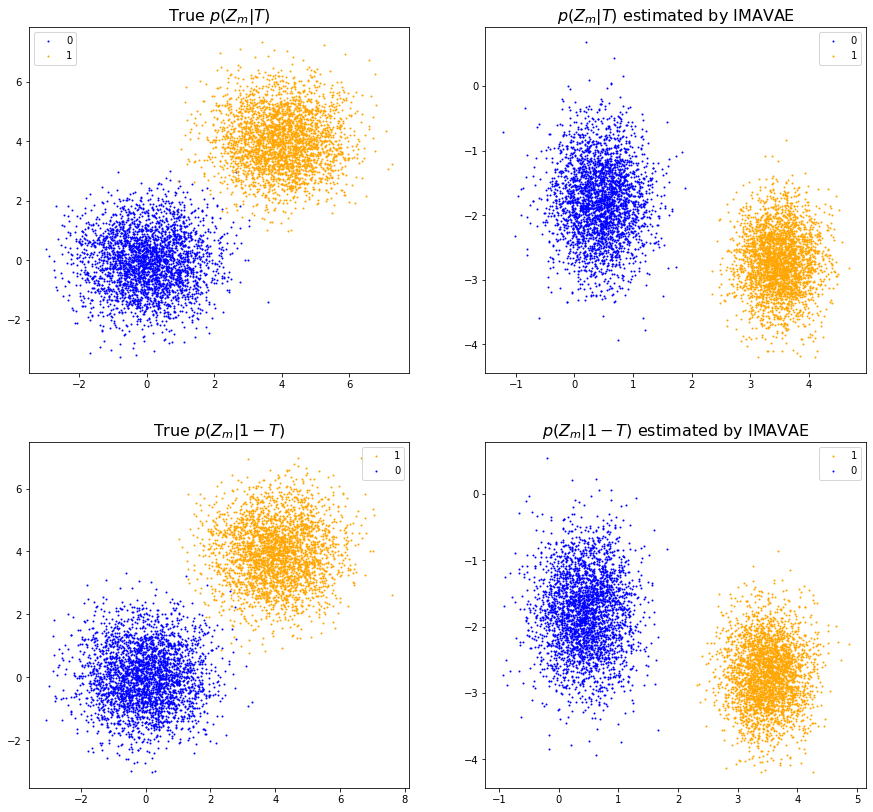

In [5]:
# Counterfactual outcomes
Z_mc = np.array([Z_m0[i,:] if T[i][0] == 1 else Z_m1[i,:] for i in range(N)])
with torch.no_grad():
    t0, t1 = torch.zeros(N, 1), torch.ones(N, 1)
    z_m0 = imavae.prior_dist.sample(*imavae.ivae.prior_params(t0))
    z_m1 = imavae.prior_dist.sample(*imavae.ivae.prior_params(t1))
    # Estimated z_m for factual outcomes
    z_m = torch.stack([z_m0[i,:] if T[i,0] == 0 else z_m1[i,:] for i in range(N)])
    # Estimated z_m for counterfactual outcomes
    z_mc = torch.stack([z_m0[i,:] if T[i,0] == 1 else z_m1[i,:] for i in range(N)]).numpy()

c_dict = {0: 'blue', 1: 'orange'}
fig, axs = plt.subplots(2, 2, figsize=(15,14))
for g in np.unique(T.squeeze()):
    i = np.where(T.squeeze() == g)
    axs[0][0].scatter(Z_m[i,0], Z_m[i,1], c=c_dict[g], label=g, s=1)
    axs[0][1].scatter(z_m[i,0], z_m[i,1], c=c_dict[g], label=g, s=1)
    axs[1][0].scatter(Z_mc[i,0], Z_mc[i,1], c=c_dict[1-g], label=1-g, s=1)
    axs[1][1].scatter(z_mc[i,0], z_mc[i,1], c=c_dict[1-g], label=1-g, s=1)
axs[0][0].legend()
axs[0][0].set_title("True $p(Z_m|T)$", size=16)
axs[0][1].legend()
axs[0][1].set_title("$p(Z_m|T)$ estimated by IMAVAE", size=16)
axs[1][0].legend()
axs[1][0].set_title("True $p(Z_m|1-T)$", size=16)
axs[1][1].legend()
axs[1][1].set_title("$p(Z_m|1-T)$ estimated by IMAVAE", size=16)

# 3. Generate Data with observed covariates

By including observed covariates $\boldsymbol{w}$, we construct the dataset as follows:
\begin{align*}
\boldsymbol{w} &\sim \mathcal{N}(\boldsymbol{0}, \sigma_w^2 \textbf{I}) \\
t &\sim \text{Bernoulli}(\text{sigmoid}(\boldsymbol{\theta}^{\text{T}} \boldsymbol{w})) \\
\boldsymbol{z}_m &\sim \mathcal{N}(0, \sigma_m^2 \textbf{I}) + c_1 \mathbb{1}(t = 1) + c_2 g(\boldsymbol{w}) \\
\boldsymbol{x} &= f(\boldsymbol{z}_m) + c_3 \epsilon_{x} \\
y &= \alpha t + \boldsymbol{\beta}^{\text{T}} \boldsymbol{z}_m + \boldsymbol{\gamma}^{\text{T}} \boldsymbol{w} + \epsilon_{y}
\end{align*}
where $c_1, c_2, c_3, \alpha \in \mathbb{R}$ are constants, $\boldsymbol{\theta}, \boldsymbol{\beta}, \boldsymbol{\gamma}$ are coefficient vectors, and $f$ and $g$ are nonlinear functions which are modeled by **un-trained** multi-layer perceptrons (MLPs). $\epsilon_{x}$ and $\epsilon_{y}$ are Gaussian noise terms.

In [6]:
N = 6000
c1, c2, c3, sigma_x, sigma_m, noise_scale = 4, 0.1, 0.1, 0.5, 1, 0.01
x_dim, z_m_dim, w_dim, hidden_dim = 50, 2, 30, 25
f = nn.Sequential(
    nn.Linear(z_m_dim, hidden_dim), 
    nn.LeakyReLU(), 
    nn.Linear(hidden_dim, x_dim)
)
g = nn.Sequential(
    nn.Linear(w_dim, hidden_dim), 
    nn.LeakyReLU(), 
    nn.Linear(hidden_dim, z_m_dim)
)

theta = np.random.uniform(-1,1,size=w_dim)
W = np.random.multivariate_normal(mean=np.zeros(w_dim), cov=sigma_x*np.eye(w_dim), size=N)
logit = W @ theta
T = np.random.binomial(n=1, p=[1/(1 + np.exp(-s)) for s in logit]).reshape(-1,1)
with torch.no_grad():
    gw = g(torch.tensor(W).float()).numpy()
Z_m0 = np.random.multivariate_normal(mean=np.zeros(z_m_dim), cov=sigma_m*np.eye(z_m_dim), size=N) + c2 * gw
Z_m1 = Z_m0 + c1
Z_m = np.array([Z_m0[i,:] if T[i][0] == 0 else Z_m1[i,:] for i in range(N)])
with torch.no_grad():
    X = f(torch.tensor(Z_m).float()).numpy()
    X += c3 * np.random.randn(X.shape[0],X.shape[1])
alpha = np.random.uniform(-2,2,size=1)
beta = np.random.uniform(-1,1,size=z_m_dim)
gamma0 = np.random.uniform(-0.5,0.5,size=w_dim)
gamma1 = np.random.uniform(-1,1,size=w_dim)
gamma = np.array([gamma0 if T[i][0] == 0 else gamma1 for i in range(N)])
noise = noise_scale * np.random.normal(size=N)
Y = (alpha * T.reshape(-1) + Z_m @ beta + np.sum(W*gamma,axis=1) + noise).reshape(-1,1)

In [7]:
Y0_M0 = (alpha * np.zeros(N) + Z_m0 @ beta + W @ gamma0 + noise).reshape(-1,1)
Y0_M1 = (alpha * np.zeros(N) + Z_m1 @ beta + W @ gamma0 + noise).reshape(-1,1)
Y1_M0 = (alpha * np.ones(N) + Z_m0 @ beta + W @ gamma1 + noise).reshape(-1,1)
Y1_M1 = (alpha * np.ones(N) + Z_m1 @ beta + W @ gamma1 + noise).reshape(-1,1)
acme_c = (Y0_M1 - Y0_M0).mean()
acme_t = (Y1_M1 - Y1_M0).mean()
ade_c = (Y1_M0 - Y0_M0).mean()
ade_t = (Y1_M1 - Y0_M1).mean()
ate = (Y1_M1 - Y0_M0).mean()
print("True ACME (control) = {:.4f}".format(acme_c))
print("True ACME (treatment) = {:.4f}".format(acme_t))
print("True ADE (control) = {:.4f}".format(ade_c))
print("True ADE (treatment) = {:.4f}".format(ade_t))
print("True ATE = {:.4f}".format(ate))

True ACME (control) = 5.2503
True ACME (treatment) = 5.2503
True ADE (control) = 1.6285
True ADE (treatment) = 1.6285
True ATE = 6.8789


# 4. Fit IMAVAE on the new dataset and evaluate mediation effect

In [8]:
imavae = IMAVAE(n_components=2, n_sup_networks=2, n_hidden_layers=2, hidden_dim=25, 
               optim_name='Adam', recon_weight=0.1, elbo_weight=1., sup_weight=1.)
WT = np.concatenate([T,W], axis=1)
_ = imavae.fit(
    X, WT, Y, # X_val=X, aux_val=WT, y_val=Y, 
    lr=1e-5, n_epochs=300, pretrain=False, verbose=1
)
acme_c_mean, acme_c_std = imavae.acme_score(WT, treatment=False)
acme_t_mean, acme_t_std = imavae.acme_score(WT, treatment=True)
ade_c_mean, ade_c_std = imavae.ade_score(WT, treatment=False)
ade_t_mean, ade_t_std = imavae.ade_score(WT, treatment=True)
ate_mean, ate_std = imavae.ate_score(WT)
print("ACME (control) = {:.4f} +/- {:.4f}".format(acme_c_mean, acme_c_std))
print("ACME (treatment) = {:.4f} +/- {:.4f}".format(acme_t_mean, acme_t_std))
print("ADE (control) = {:.4f} +/- {:.4f}".format(ade_c_mean, ade_c_std))
print("ADE (treatment) = {:.4f} +/- {:.4f}".format(ade_t_mean, ade_t_std))
print("ATE = {:.4f} +/- {:.4f}".format(ate_mean, ate_std))

Beginning Training


Epoch: 299, Current Training MSE: 0.00989076, Current Pred Metric: [1.6729296, 1


Saving the last epoch with training MSE: 0.00989076 and Pred Metric: [1.6729296, 1.6729296]
ACME (control) = 5.5271 +/- 0.0138
ACME (treatment) = 5.5278 +/- 0.0144
ADE (control) = 1.3097 +/- 0.0000
ADE (treatment) = 1.3097 +/- 0.0000
ATE = 6.8386 +/- 0.0133


### 4.1 Does the latent feature learned by IMAVAE recover the true mediator?

Text(0.5, 1.0, 'Mediator estimated by IMAVAE')

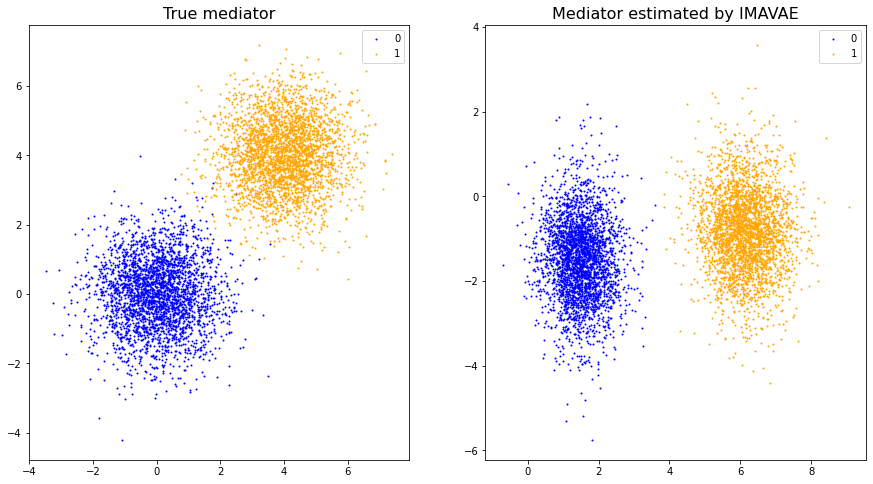

In [9]:
with torch.no_grad():
    t0, t1 = torch.zeros(N, 1), torch.ones(N, 1)
    t0, t1 = torch.cat([t0, torch.tensor(W).float()], dim=1), torch.cat([t1, torch.tensor(W).float()], dim=1)
    z_m0 = imavae.prior_dist.sample(*imavae.ivae.prior_params(t0))
    z_m1 = imavae.prior_dist.sample(*imavae.ivae.prior_params(t1))
    z_m = torch.stack([z_m0[i,:] if T[i,0] == 0 else z_m1[i,:] for i in range(N)])

c_dict = {0: 'blue', 1: 'orange'}
fig, axs = plt.subplots(1, 2, figsize=(15,8))
for g in np.unique(T.squeeze()):
    i = np.where(T.squeeze() == g)
    axs[0].scatter(Z_m[i,0], Z_m[i,1], c=c_dict[g], label=g, s=1)
    axs[1].scatter(z_m[i,0], z_m[i,1], c=c_dict[g], label=g, s=1)
axs[0].legend()
axs[0].set_title("True mediator", size=16)
axs[1].legend()
axs[1].set_title("Mediator estimated by IMAVAE", size=16)